In [2]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Sequential, model_from_json

from keras import backend as K

%matplotlib inline

directories = ["../object-dataset/","../object-detection-crowdai/"]

labels = ['Frame','xmin','ymin','xmax','ymax','FilePath','Label']
df1 = pd.read_csv(directories[0] + os.path.sep + "labels.csv",header=0,delimiter=" ")
df1["FilePath"] = directories[0] + df1["Frame"]
df1 = df1[labels]
df_vehicles1 = df1[(df1['Label']=='car') | (df1['Label']=='truck')].reset_index()
df_vehicles1.head()


Using TensorFlow backend.


,index,Frame,xmin,ymin,xmax,ymax,FilePath,Label
0,0,1478019952686311006.jpg,950,574,1004,620,../object-dataset/1478019952686311006.jpg,car
1,2,1478019953180167674.jpg,872,586,926,632,../object-dataset/1478019953180167674.jpg,car
2,3,1478019953689774621.jpg,686,566,728,618,../object-dataset/1478019953689774621.jpg,truck
3,4,1478019953689774621.jpg,716,578,764,622,../object-dataset/1478019953689774621.jpg,car
4,5,1478019953689774621.jpg,826,580,880,626,../object-dataset/1478019953689774621.jpg,car


In [3]:
df2 = pd.read_csv(directories[1] + os.path.sep + "labels.csv")
df2["FilePath"] = directories[1] +df2 ["Frame"]
df2 = df2[labels]
df_vehicles2 = df2[(df2['Label']=='Car') | (df2['Label']=='Truck')].reset_index()
df_vehicles2.head()



,index,Frame,xmin,ymin,xmax,ymax,FilePath,Label
0,0,1479498371963069978.jpg,785,533,905,644,../object-detection-crowdai/147949837196306997...,Car
1,1,1479498371963069978.jpg,89,551,291,680,../object-detection-crowdai/147949837196306997...,Car
2,2,1479498371963069978.jpg,268,546,383,650,../object-detection-crowdai/147949837196306997...,Car
3,3,1479498371963069978.jpg,455,522,548,615,../object-detection-crowdai/147949837196306997...,Truck
4,4,1479498371963069978.jpg,548,522,625,605,../object-detection-crowdai/147949837196306997...,Truck


(130680, 9)


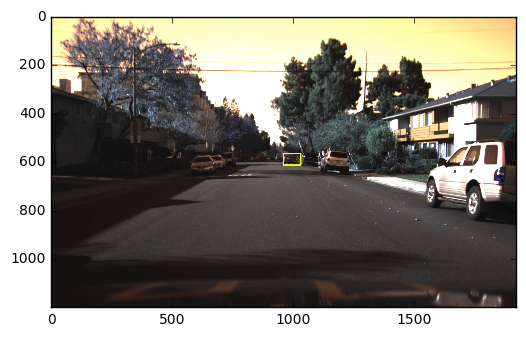

(1200, 1920, 3)


In [4]:
df_vehicles = pd.concat([df_vehicles1,df_vehicles2]).reset_index()

print(df_vehicles.shape)


index = 130670
img = cv2.imread(df_vehicles["FilePath"][index])
xmin = df_vehicles["xmin"][index]
ymin = df_vehicles["ymin"][index]
xmax = df_vehicles["xmax"][index]
ymax = df_vehicles["ymax"][index]

cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,0),3)
plt.imshow(img)
plt.show()
df_vehicles.head()

print(img.shape)

In [5]:
df_vehicles.tail()

,level_0,index,Frame,xmin,ymin,xmax,ymax,FilePath,Label
130675,66384,72059,1479506176491553178.jpg,958,559,1045,621,../object-detection-crowdai/147950617649155317...,Car
130676,66385,72060,1479506176491553178.jpg,1038,558,1122,630,../object-detection-crowdai/147950617649155317...,Car
130677,66386,72061,1479506176491553178.jpg,667,558,747,626,../object-detection-crowdai/147950617649155317...,Car
130678,66387,72062,1479506176491553178.jpg,730,568,818,613,../object-detection-crowdai/147950617649155317...,Car
130679,66388,72063,1479506176491553178.jpg,435,551,532,589,../object-detection-crowdai/147950617649155317...,Car


130680


/Users/rushabh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


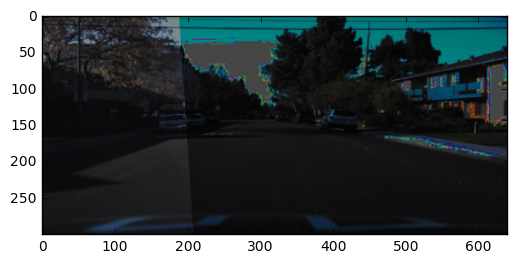

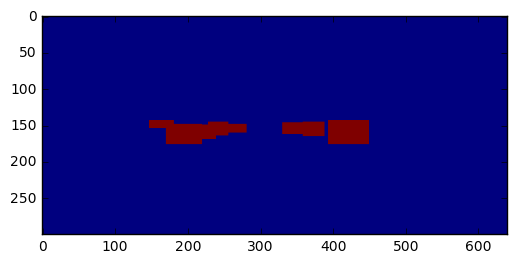

In [15]:
def augment_brightness_camera_images(image):
    
    ### Augment brightness 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1


def trans_image(image,bb_boxes_f,trans_range):
    # Translation augmentation
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    bb_boxes_f['xmin'] = bb_boxes_f['xmin']+tr_x
    bb_boxes_f['xmax'] = bb_boxes_f['xmax']+tr_x
    bb_boxes_f['ymin'] = bb_boxes_f['ymin']+tr_y
    bb_boxes_f['ymax'] = bb_boxes_f['ymax']+tr_y
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,bb_boxes_f


def stretch_image(img,bb_boxes_f,scale_range):
    # Stretching augmentation 
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
    
    return img,bb_boxes_f


# This function is used to augment the data
# and add random shadows to the image
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


def get_image_name(df,ind,size=(640,300),augmentation = False,trans_range = 20,scale_range=20):
    ### Get image by name
    
    file_name = df['FilePath'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    
    #print(name_str)
    #print(file_name)
    bb_boxes = df[df['Frame'] == name_str].reset_index(drop=True)
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img = add_random_shadow(img)
        img,bb_boxes = trans_image(img,bb_boxes,trans_range)
        img,bb_boxes = stretch_image(img,bb_boxes,scale_range)
        img = augment_brightness_camera_images(img)
        
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1])
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1])
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0])
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0])
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    
    return name_str,img,bb_boxes

def get_mask_seg(img,bb_boxes_f):
    
    #### Get mask 
    
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]]= 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
    return img_mask


def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();


def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
    
def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
    
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')
    plt.axis('off');
    plt.show()
    

print(len(df_vehicles))

name,img,bboxes = get_image_name(df_vehicles,130679,augmentation=True)

img_mask = get_mask_seg(img,bboxes)
#plot_im_mask(img,img_mask)
#plot_im_bbox(img,bboxes)

im = np.array(img,dtype=np.uint8)
#im_mask = np.array(img_mask,dtype=np.uint8)

plt.imshow(im)
plt.show()
plt.imshow(img_mask[:,:,0])
plt.show()


/Users/rushabh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


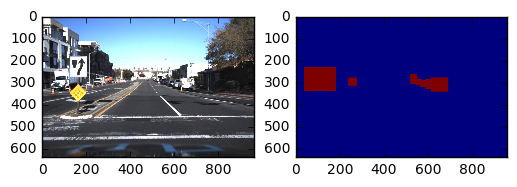

In [35]:
img_rows = 640
img_cols = 960

def get_data(df,batch_size=32,augmentation=True):
    batch_images = []
    batch_masks = []
    while 1 :
        for i in range(batch_size):
            random_index = np.random.randint(len(df))
            name,img,bboxes = get_image_name(df,random_index,size=(int(img_cols),int(img_rows)),augmentation=False)
            img_mask = get_mask_seg(img,bboxes)
            im = np.array(img,dtype=np.uint8)
            im = im/255.
            batch_images.append(im)
            batch_masks.append(img_mask)
        yield np.array(batch_images),np.array(batch_masks)
        

def get_training_data(df,batch_size=32):
    return get_data(df,batch_size=batch_size,augmentation=True)

def get_testing_data(df,batch_size=32):
    return get_data(df,batch_size=batch_size,augmentation=False)


def display_img_mask(img,imgmask):
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.subplot(1,2,2)
    plt.imshow(imgmask[:,:,0])
    plt.show()
        
batch_images,batch_mask = next(get_training_data(df_vehicles))

display_img_mask(batch_images[0],batch_mask[0])


In [10]:
batch_images[0]

array([[[ 0.98431373,  1.        ,  0.96470588],
        [ 1.        ,  0.97254902,  0.91372549],
        [ 0.8745098 ,  0.69411765,  0.61176471],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.96470588,  1.        ,  0.98823529],
        [ 1.        ,  0.99215686,  0.94117647],
        [ 1.        ,  0.92156863,  0.82745098],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       [[ 0.95294118,  1.        ,  1.        ],
        [ 0.99607843,  0.99607843,  0.96078431],
        [ 1.        ,  0.98039216,  0.87843137],
        ..., 
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        ]],

       ..., 
       [[ 0.11764706,  0.12156863,  0.14117647],
        

In [36]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred,smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [37]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=3)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=3)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=3)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=3)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)

    return model





In [38]:
model = get_small_unet()
model.compile(optimizer='adam', 
              loss=IOU_calc_loss, metrics=[IOU_calc])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 640, 960, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_69 (Convolution2D) (None, 640, 960, 8)   224         input_6[0][0]                    
____________________________________________________________________________________________________
convolution2d_70 (Convolution2D) (None, 640, 960, 8)   584         convolution2d_69[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 320, 480, 8)   0           convolution2d_70[0][0]           
___________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint("model.h5", monitor='loss', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint]

if os.path.isfile("model.json"):
    with open('model.json', 'r') as jfile:
        if jfile is not None:
            model = model_from_json(json.load(jfile))
            model.compile("adam", "mse")
            weights_file = "model.h5"
            model.load_weights(weights_file)
            print("Loading model from file")
else:
    model = get_small_unet()
    model.compile(optimizer='adam', 
              loss=IOU_calc_loss, metrics=[IOU_calc])
    print("Creating a fresh new model")

model.fit_generator(get_training_data(df=df_vehicles,batch_size=8),nb_epoch=20,                  
                        callbacks=callbacks_list,
                        validation_data=get_testing_data(df=df_vehicles),
                        nb_val_samples=32,samples_per_epoch=256)


Creating a fresh new model
Epoch 1/20


/Users/rushabh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
